In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'F:\\projects\\generative-models\\examples\\torch_autoencoder'

In [3]:
%cd ../..
%pwd

F:\projects\generative-models


'F:\\projects\\generative-models'

In [4]:
import torch
from gempy.torch.encoder import ConvEncoder
from gempy.torch.decoder import ConvDecoder
from gempy.torch.auto_encoder import AutoEncoder

In [5]:
input_dim = (1, 28, 28)
z_dim = (4, )
z_labels = ('z', )

In [6]:
device = 'cpu'
if torch.cuda.is_available():
    print (f'GPU available')
    device = 'cuda'

x_random = torch.randn(1, *input_dim)
x_random = x_random.to(device)

GPU available


In [7]:
encoder = ConvEncoder(
    input_dim=input_dim,
    filters=(32, 64, 64, 64),
    #filters=(8, 16, 16, 16),
    kernel_size=(3, 3, 3, 3),
    strides=(1, 2, 2, 1),
    activation='leaky_relu',
    latent_dim=z_dim,
    latent_labels=z_labels,
    latent_activation='sigmoid',
)

encoer = encoder.to(device)
encoder

ConvEncoder(
  (conv_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (latent_flatten): Flatten(start_dim=1, end_dim=-1)
  (latent_z): Linear(in_features=576, out_features=4, bias=True)
)

In [8]:
decoder = ConvDecoder(
    latent_dim=z_dim,
    latent_upscale=(64, 3, 3),
    filters=[64, 64, 32, 1],
    #filters=[16, 16, 8, 1],
    kernel_size=[3, 4, 4, 3],
    strides=[1, 2, 2, 1],
    activation=['leaky_relu', 'leaky_relu', 'leaky_relu', 'sigmoid'],
    latent_merge=False,
    latent_activation=None,
)

decoder = decoder.to('cuda')
decoder

ConvDecoder(
  (decode_latent_0): Linear(in_features=4, out_features=576, bias=True)
  (decode_conv_t_0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (decode_conv_t_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (decode_conv_t_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
  (decode_conv_t_3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [9]:
for l in decoder.conv_stack:
    print('layer activation: ', l[-2])

layer activation:  <function leaky_relu at 0x000001AB67959040>
layer activation:  <function leaky_relu at 0x000001AB67959040>
layer activation:  <function leaky_relu at 0x000001AB67959040>
layer activation:  <built-in method sigmoid of type object at 0x00007FFBDF946620>


In [10]:
auto_encoder = AutoEncoder(
    encoder=encoder,
    decoder=decoder,
)

auto_encoder = auto_encoder.to(device)
auto_encoder

AutoEncoder(
  (encoder): ConvEncoder(
    (conv_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (latent_flatten): Flatten(start_dim=1, end_dim=-1)
    (latent_z): Linear(in_features=576, out_features=4, bias=True)
  )
  (decoder): ConvDecoder(
    (decode_latent_0): Linear(in_features=4, out_features=576, bias=True)
    (decode_conv_t_0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (decode_conv_t_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
    (decode_conv_t_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (decode_conv_t_3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)

In [11]:
print('input shape     :', auto_encoder.encoder.conv_stack_shape_in)
print('latent shape     :', auto_encoder.encoder.conv_stack_shape_out)
print('z shape          :', z_dim)
print('output shape    :', auto_encoder.decoder.conv_stack_shape_out)

input shape     : (1, 28, 28)
latent shape     : (64, 3, 3)
z shape          : (4,)
output shape    : (1, 28, 28)


In [12]:
y = auto_encoder(x_random)

print('latent space    :', encoder.latent_torch)
print('output shape    :', y.shape)


latent space    : {'z': tensor([[0.5024, 0.5061, 0.4998, 0.5098]], device='cuda:0',
       grad_fn=<SigmoidBackward>)}
output shape    : torch.Size([1, 1, 28, 28])


In [13]:
for p in auto_encoder.parameters():
    print(p.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([4, 576])
torch.Size([4])
torch.Size([576, 4])
torch.Size([576])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64, 64, 4, 4])
torch.Size([64])
torch.Size([64, 32, 4, 4])
torch.Size([32])
torch.Size([32, 1, 3, 3])
torch.Size([1])


In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

def get_cifar10(batch_size, dataset_directory, dataloader_workers):
    # Prepare dataset for training
    train_transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    train_dataset = torchvision.datasets.CIFAR10(root=dataset_directory, train=True,
                                                 download=True, transform=train_transformation)
    
    test_dataset =  torchvision.datasets.CIFAR10(root=dataset_directory, train=False,
                                                 download=True, transform=train_transformation)

    # Prepare Data Loaders for training and validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               pin_memory=True, num_workers=dataloader_workers)

    return train_dataset, train_loader

def get_MNIST(batch_size, dataset_directory, dataloader_workers):
    # Prepare dataset for training
    train_transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    
    train_dataset = torchvision.datasets.MNIST(root=dataset_directory, train=True,
                                               download=True, transform=train_transformation)
    
    test_dataset =  torchvision.datasets.MNIST(root=dataset_directory, train=False,
                                               download=True, transform=train_transformation)

    # Prepare Data Loaders for training and validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               pin_memory=True, num_workers=dataloader_workers)

    return train_dataset, train_loader

In [15]:
train_dataset, train_loader = get_MNIST(64, 'examples/torch_autoencoder/data/MNIST', 4)

In [16]:
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(auto_encoder.parameters(), lr=1e-4)

In [17]:
# mean-squared error loss
criterion = torch.nn.MSELoss()

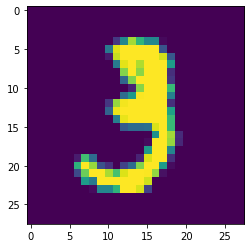

In [18]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[10][0].detach().numpy().transpose(1,2,0))

In [19]:
epochs = 100

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        # batch_features = batch_features.view(-1, 784).to(device)
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = auto_encoder(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/100, loss = 0.082558
epoch : 2/100, loss = 0.067470
epoch : 3/100, loss = 0.067370
epoch : 4/100, loss = 0.067330
epoch : 5/100, loss = 0.067324
epoch : 6/100, loss = 0.067320
epoch : 7/100, loss = 0.067306
epoch : 8/100, loss = 0.067309
epoch : 9/100, loss = 0.067307
epoch : 10/100, loss = 0.067307
epoch : 11/100, loss = 0.067304
epoch : 12/100, loss = 0.067300
epoch : 13/100, loss = 0.067308
epoch : 14/100, loss = 0.067294
epoch : 15/100, loss = 0.067297
epoch : 16/100, loss = 0.067293
epoch : 17/100, loss = 0.067288
epoch : 18/100, loss = 0.067291
epoch : 19/100, loss = 0.067288
epoch : 20/100, loss = 0.067287
epoch : 21/100, loss = 0.067285
epoch : 22/100, loss = 0.067287
epoch : 23/100, loss = 0.067285
epoch : 24/100, loss = 0.067287
epoch : 25/100, loss = 0.067287
epoch : 26/100, loss = 0.067284
epoch : 27/100, loss = 0.067286
epoch : 28/100, loss = 0.067283
epoch : 29/100, loss = 0.067280
epoch : 30/100, loss = 0.067286
epoch : 31/100, loss = 0.067281
epoch : 32/100, l

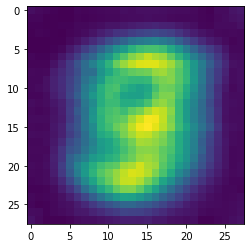

In [28]:
import numpy as np

z_rand = np.random.rand(*z_dim)
t_rand = torch.from_numpy(z_rand[None, ...]).float().to(device)

y_rand = auto_encoder.decoder(t_rand)

y = y_rand[0].detach().cpu().numpy()
plt.imshow(y.transpose(1,2,0))